In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
dir = '/Users/signapoop/Desktop/autotune'
os.chdir(dir)
from autotune.core.HyperbandOptimiser import HyperbandOptimiser
from autotune.core.RandomOptimiser import RandomOptimiser

In [32]:
hyperband = []
random = []
n = 4

for i in range(1,n+1):

    problem_text = "cifar_5hps_" + str(i)
    path = '/Users/signapoop/Desktop/results/' + problem_text
    os.chdir(path)
    file = open("results.pkl",'rb')
    object_file = pickle.load(file)
    file.close()

    # Unpack file
    hyperband.append(object_file[0])
    random.append(object_file[1])

In [33]:
def predecessor_t(seq, t):
    assert seq[0] == 0, "First checkpoint must be 0"
    for i in range(len(seq)):
        if seq[i] > t:
            return i -1
    return i 

def value_at_time(opt, t):
    time_index = predecessor_t(opt.checkpoints, t)
    return opt.Y_best[time_index]

def augment_sequences(opt):
    opt.checkpoints.insert(0,0)
    opt.Y_best.insert(0,1)

In [34]:
# augments sequences, prepending checkpoint t=0, Y_best=1
for opt in hyperband: 
    augment_sequences(opt)

for opt in random: 
    augment_sequences(opt)

In [35]:
for h in hyperband:
    print(len(h.checkpoints))

13
13
13
13


In [36]:
for r in random:
    print(len(r.checkpoints))

19
19
16
19


In [37]:
seq = random[0].checkpoints
print(seq)
print(predecessor_t(seq, 4900))
print(value_at_time(random[0], 4900))

[0, 186.84311699867249, 406.3686490058899, 575.5448751449585, 741.9263191223145, 967.0910971164703, 1244.4578790664673, 1484.6137840747833, 1658.5234541893005, 1838.2549901008606, 2257.2224321365356, 2567.191892147064, 2756.2931730747223, 2949.550628185272, 3158.684194087982, 3441.031387090683, 3700.5599122047424, 3972.90052318573, 4353.779044151306]
18
0.1961


In [38]:
def average_opt_results(optimisers):
    t_end = max([opt.checkpoints[-1] for opt in optimisers])
    print(t_end)
    t_seq = np.linspace(0, t_end, num=250)
    
    y_seq = np.zeros((len(optimisers),len(t_seq)))
    for i in range(len(optimisers)):
        for j in range(len(t_seq)):
            y_seq[i][j] = value_at_time(optimisers[i], t_seq[j])
    return t_seq, y_seq

In [39]:
random_t_seq, random_y_seq = average_opt_results(random)
print(random_y_seq.shape)
hyperband_t_seq, hyperband_y_seq = average_opt_results(hyperband)
print(hyperband_y_seq.shape)

5314.18975997
(4, 250)
5069.71345592
(4, 250)


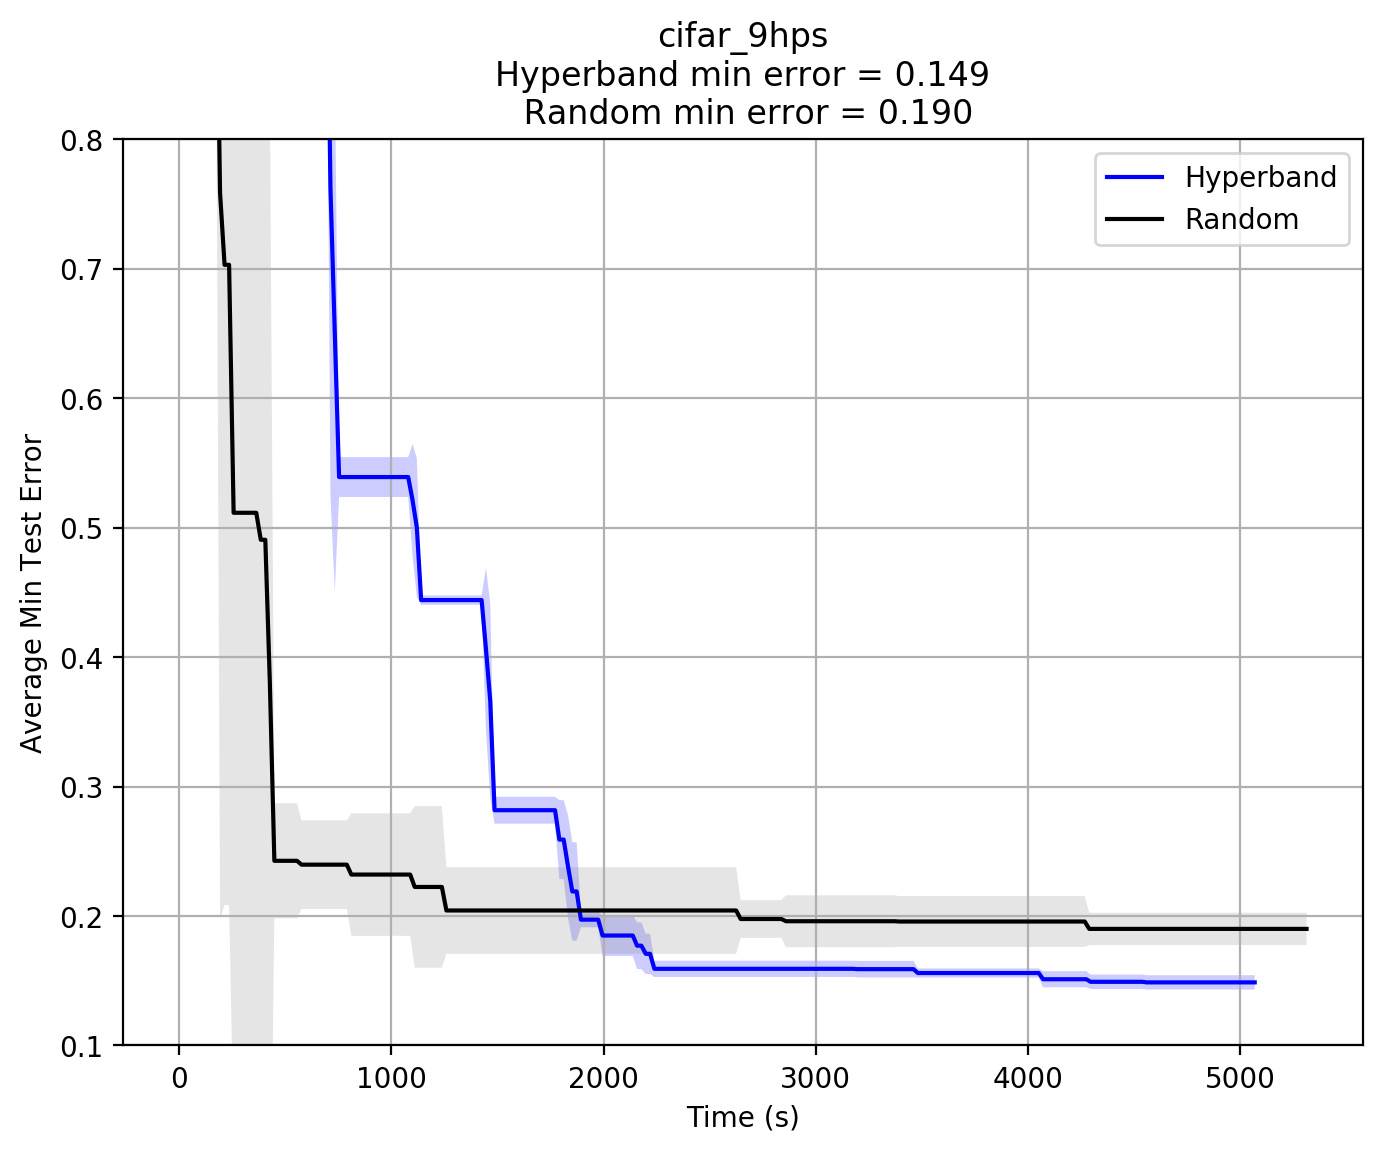

In [44]:
r_a = np.average(random_y_seq, 0)
h_a = np.average(hyperband_y_seq, 0)
r_s = np.std(random_y_seq, 0)
h_s = np.std(hyperband_y_seq, 0)

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=200)
ax.plot(hyperband_t_seq, h_a, '-b', label="Hyperband")
ax.fill_between(hyperband_t_seq, h_a-h_s, h_a+h_s, facecolor='blue', alpha=0.2)

ax.plot(random_t_seq, r_a, '-k', label="Random")
ax.fill_between(random_t_seq, r_a-2*r_s, r_a+2*r_s, facecolor='grey', alpha=0.2)
ax.set_ylim(0.1,0.8)

ax.grid()
plt.ylabel('Average Min Test Error')
plt.xlabel('Time (s)')
plt.legend()

problem_text = "cifar_9hps"

res = "Hyperband min error = {:.3f}\n Random min error = {:.3f}".format(min(hyperband_ave), min(random_ave))
title = problem_text + "\n" + res
plt.title(title)
    
plt.show()

In [41]:
random_std = np.std(random_y_seq, 0)

In [42]:
random_std

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.28059528,
        0.24732884,  0.24732884,  0.23984754,  0.23984754,  0.23984754,
        0.23984754,  0.23984754,  0.23984754,  0.25891212,  0.25891212,
        0.22960506,  0.02220974,  0.02220974,  0.02220974,  0.02220974,
        0.02220974,  0.02220974,  0.01712971,  0.01712971,  0.01712971,
        0.01712971,  0.01712971,  0.01712971,  0.01712971,  0.01712971,
        0.01712971,  0.01712971,  0.01712971,  0.02367302,  0.02367302,
        0.02367302,  0.02367302,  0.02367302,  0.02367302,  0.02367302,
        0.02367302,  0.02367302,  0.02367302,  0.02367302,  0.02367302,
        0.02367302,  0.02367302,  0.03120597,  0.03120597,  0.03120597,
        0.03120597,  0.03120597,  0.03120597,  0.03120597,  0.01673266,
        0.01673266,  0.01673266,  0.01673266,  0.01673266,  0.01673266,
        0.01673266,  0.01673266,  0.01673266,  0.01673266,  0.01